# Proximal Policy Optimization

---
Code based on Udacity exercise on PPO to solve the Atari-pong game using the pixels of two succeeding frames as an input.<br>
Code changed to work with continous actions space following <br>
https://youtu.be/BvZvx7ENZBw<br>
https://github.com/vwxyzjn/PPO-Implementation-Deep-Dive/blob/master/ppo_continuous_action.py<br>

In this notebook, we learned how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
no_graphics=True
#no_graphics=False
env = UnityEnvironment(file_name='C:\EigeneLokaleDaten\DeepRL\Value-based-methods\p2_continuous-control\Reacher_Windows_x86_64_single_agent\Reacher.exe', no_graphics=no_graphics)
#env = UnityEnvironment(file_name='C:\EigeneLokaleDaten\DeepRL\Value-based-methods\p2_continuous-control\Reacher_Windows_x86_64_multiple_agents\Reacher.exe', no_graphics=no_graphics)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Train a PPO agent - use classroom exercise code to start exploring hyperparameter and network architecture

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

# for the moment start with one agent alone - no paralell code execution 
#import PPO_utils
#device = PPO_utils.device
#print("using device: ",device)

using device:  cpu


In [6]:
from torch.distributions.normal import Normal

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


# set up a fully connected (fc) neural net
# the output is the action vector (dim=4)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_dim = 33
        self.action_dim = 4
        self.fc1 = nn.Linear(self.state_dim, 64*2*2)   # added size * 2 ...
        self.fc2 = nn.Linear(64*2*2, 32*2*2)           # added size * 2 ...
        self.fc3 = nn.Linear(32*2*2, 16*1)
        self.fc4 = nn.Linear(16*1,self.action_dim)        
        self.reset_parameters()
        
        self.epsilon = 1e-4
        
        self.actor_logstd = nn.Parameter(torch.zeros(self.action_dim)+self.epsilon) # state-independent stds
        print(self.actor_logstd)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
            
    def actor_mean(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.tanh(self.fc4(x))        
    
    def prob_4_action(self,x,action):
        action_means = self.actor_mean(x)                   
        action_logstd = self.actor_logstd.expand_as(action_means)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_means,action_std)  # ->  The probability is the probabilty of the actions value under the given normal distribution. 
        #print(action)
        #print(probs.log_prob(action).sum())
        #print(probs.entropy().sum())
        return action, probs.log_prob(action).sum(), probs.entropy().sum()
    
    def prob_4_action_sum1(self,x,action):
        action_means = self.actor_mean(x)                   
        action_logstd = self.actor_logstd.expand_as(action_means)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_means,action_std)  # ->  The probability is the probabilty of the actions value under the given normal distribution. 
        #print(action)
        #print(probs.log_prob(action).sum())
        #print(probs.entropy().sum())
        return action, probs.log_prob(action).sum(1), probs.entropy().sum()
                
    def forward(self, x):  
        action_means = self.actor_mean(x)                   
        action_logstd = self.actor_logstd.expand_as(action_means)
        #action_logstd = self.actor_logstd
        action_std = torch.exp(action_logstd)
        probs = Normal(action_means,action_std)
        action = probs.sample()
        # sum: assuming independet action components 
        return action, probs.log_prob(action).sum(), probs.entropy().sum()   

# run your own policy!
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

Parameter containing:
tensor([1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04], requires_grad=True)


In [8]:
policy(torch.from_numpy(states[0]).float().to(device))
print(policy.prob_4_action(torch.from_numpy(states[0]).float().to(device),torch.from_numpy(np.array([0.5,0.5,0.5,0.5]))))
print(policy.prob_4_action(torch.from_numpy(states[0]).float().to(device),torch.from_numpy(np.array([0.5,0.5,0.5,0.51]))))

(tensor([0.5000, 0.5000, 0.5000, 0.5000], dtype=torch.float64), tensor(-4.4945, dtype=torch.float64, grad_fn=<SumBackward0>), tensor(6.0758, grad_fn=<SumBackward0>))
(tensor([0.5000, 0.5000, 0.5000, 0.5100], dtype=torch.float64), tensor(-4.4987, dtype=torch.float64, grad_fn=<SumBackward0>), tensor(6.0758, grad_fn=<SumBackward0>))


In [9]:
#print(states)
policy(torch.from_numpy(states).float().to(device))
print(policy.prob_4_action(torch.from_numpy(states[0]).float().to(device),torch.from_numpy(np.array([0.5,0.5,0.5,0.5]))))
print(policy.prob_4_action(torch.from_numpy(states[0]).float().to(device),torch.from_numpy(np.array([0.5,0.5,0.5,0.51]))))

(tensor([0.5000, 0.5000, 0.5000, 0.5000], dtype=torch.float64), tensor(-4.4945, dtype=torch.float64, grad_fn=<SumBackward0>), tensor(6.0758, grad_fn=<SumBackward0>))
(tensor([0.5000, 0.5000, 0.5000, 0.5100], dtype=torch.float64), tensor(-4.4987, dtype=torch.float64, grad_fn=<SumBackward0>), tensor(6.0758, grad_fn=<SumBackward0>))


In [10]:
policy=Policy().to(device)
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
#actions = policy(torch.from_numpy(np.array(states)[0]).float().to(device)).squeeze().cpu().detach().numpy()      
print(len(states))
print(states[0])

with torch.no_grad():
    actions_t, prob_logs, prob_entr = policy(torch.from_numpy(states[0]).float().to(device))
actions = actions_t.squeeze().cpu().detach().numpy()      
print(actions)
print(prob_logs)

print(policy.prob_4_action(torch.from_numpy(states[0]).float().to(device),torch.from_numpy(actions)))

Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)
1
[ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]
[ 0.11947484 -0.4906816   2.5899308   1.6673676 ]
tensor(-7.5681)
(tensor([ 0.1195, -0.4907,  2.5899,  1.6674]), tensor(-7.5681, grad_fn=<SumBackward0>), tensor(6.0758, grad_fn=<SumBackward0>))


In [8]:
do_scaling = True
if do_scaling:
    print('load state scaling')
    data = np.load('state_scale.npz')
    scale = data['scale_int']
else:
    scale = np.ones(33,)

# collect trajectory for a single agent
def collect_trajectory(env, policy, tmax=1000, num_agents = 1):    
    debug_ = False 
    action_size = 4
    
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    actions_list=[]

    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    states = states/scale
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    for jj in range(1):
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        # print(actions.shape)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment

    if debug_:
        print('ACTION:',actions)
    next_states = env_info.vector_observations         # get next state (for each agent)   
    next_states = next_states/scale

    if debug_:
        print('START STATES:')
        print(states)
        print(type(states))
        print(states.shape)
        #print(np.array(states)[0])
        
    with torch.no_grad():
        actions_t, prob_logs, prob_entr = policy(torch.from_numpy(states).float().to(device))
    actions = actions_t.squeeze().cpu().detach().numpy()    
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    
    ##actions = policy(torch.from_numpy(states).float().to(device)).squeeze().cpu().detach().numpy()
                     
    #actions = policy(torch.from_numpy(states).float().to(device)).squeeze().cpu().detach().numpy()        
    if debug_:
        print('###')
        print('ACTION after Policy:',actions)
        print('###')
                
    for t in range(tmax):   
        # action will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        
        with torch.no_grad():
            actions_t, prob_logs, prob_entr = policy(torch.from_numpy(states).float().to(device))
        actions = actions_t.squeeze().cpu().detach().numpy()    
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        ## actions = policy(torch.from_numpy(states).float().to(device)).squeeze().cpu().detach().numpy()                    
        
        # advance the game 
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = next_states/scale
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step        
        
        # store the result
        prob_list.append(prob_logs)
        state_list.append(torch.from_numpy(states).float().to(device))
        reward_list.append(rewards)
        actions_list.append(actions)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if np.any(dones):                                  # exit loop if episode finished
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, \
        actions_list, reward_list

load state scaling


In [12]:
actions = np.random.randn(num_agents, action_size)
print(actions.shape)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
print(actions.shape)
env_info = env.step(actions)[brain_name]           # send all actions to tne environment

(1, 4)
(1, 4)


In [13]:
for jj in range(2):  # two sample trajectories...
    prob_list, state_list, \
        actions_list, reward_list = collect_trajectory(env,policy,tmax=100)
    print(reward_list)
    print(prob_list)
    print(actions_list)

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[tensor(-4.7066), tensor(-8.4354), tensor(-7.1477), tensor(-8.5732), tensor(-8.0392), tensor(-5.0285), tensor(-8.3316), tensor(-7.7601), tensor(-5.0781), tensor(-5.5658), tensor(-7.4695), tensor(-10.0484), tensor(-9.6006), tensor(-5.1460), tensor(-6.3476), tensor(-4.4493), tensor(-4.3913), tensor(-

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[tensor(-7.1636), tensor(-6.8154), tensor(-4.6674), tensor(-8.4697), tensor(-4.6840), tensor(-6.3230), tensor(-4.5235), tensor(-5.8455), tensor(-5.4868), tensor(-6.0027), tensor(-6.9539), tensor(-5.3057), tensor(-5.3391), tensor(-5.3669), tensor(-5.6488), tensor(-6.3372), tensor(-8.5852), tensor(-6

In [9]:
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.001,
                      normalize_rewards = False # set to True for multi agent training env...                     
                     ):  # beta = 0.01 before
    debug_ = False
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    if debug_:
        print('rewards_future',rewards_future)
        print('rewards_future.shape',rewards_future.shape)
        
    if normalize_rewards:
        mean = np.mean(rewards_future, axis=1)
        std = np.std(rewards_future, axis=1) + 1.0e-10
        print('rewards_normalized - mean',mean)
        print('rewards_normalized - std',std)
        rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
        print('rewards_normalized',rewards_normalized)
    else:
        rewards_normalized = rewards_future.copy()
    
    if debug_:
        print('actions:',actions)
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.float, device=device)  # this was int8 before :( 
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    #new_probs = states_to_prob(policy, states)    
    

    new_probs = 0 

    for state, action in zip(states, actions):                
                actions_t, prob_logs, prob_entr = policy.prob_4_action(state.float().to(device),action) # np.stack(states)
                new_probs += prob_logs
    
    #actions_t, prob_logs, prob_entr = policy.prob_4_action_sum1(torch.from_numpy(states).float().to(device),actions) # np.stack(states)
    #    new_probs = prob_logs
        
    #new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
        
    
    # ratio for clipping
    ###################''''''DEBUG!!!!
    logratio = new_probs - old_probs.sum()    # ratio = new_probs/old_probs  #### BUG !!!! why old_probs list single probs, but new probs_ single value?
    ratio = logratio.exp()    

    if debug_ == True:
        print('old_probs',old_probs)
        print('old_probs',old_probs.sum())
        print('new_probs',new_probs)        
        print('ratio:',ratio)
        print('exp:',torch.exp(new_probs - old_probs.sum()))

    
    if debug_:
        print('RATIO: Shape:',ratio.shape)
        print('REWARDS: Shape:',rewards.shape)
    
    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    
    rewards = rewards[:,:,None]
    if debug_:
        print('ratio*rewards',(ratio*rewards).shape)
        print('clip*rewards',(clip*rewards).shape)
    
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    if debug_:
        print('ratio*rewards:',ratio*rewards)
        print('clip*rewards:',clip*rewards)
        print('clipped_surrogate:',clipped_surrogate)
    
        print('new_probs',new_probs)
        print('old_probs',old_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    # entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
    #    (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    #return torch.mean(clipped_surrogate + beta*prob_entr)
    return torch.mean(clipped_surrogate)


In [15]:
'''
for jj in range(2):  # two sample trajectories...
    prob_list, state_list, \
        actions_list, reward_list = collect_trajectory(env,policy,tmax=100)
    print(reward_list)
    print(prob_list)
    print(actions_list)
    
   ''' 
    
old_probs, states, actions, rewards = \
        collect_trajectory(env, policy, tmax=1000)
                
   
L = -clipped_surrogate(policy, np.array(old_probs).sum(), states, actions, rewards, discount=0.99999, epsilon=0.1, beta=0.001)
optimizer.zero_grad()
L.backward()
torch.nn.utils.clip_grad_norm(policy.parameters(), 1)   # take advise from Attempt 3 / Udacity Course 
optimizer.step()

    

C:\ProgramData\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
C:\ProgramData\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


In [16]:
# Sanity Check - get elements from buffer and check if log probability can be reproduced...
# Note: It's important to convert numpy to float and device for same numerical accuracy -> otherwhise big difference in probs!!

actions = np.random.randn(num_agents, action_size)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#print(actions)
env_info = env.step(actions)[brain_name]           # send all actions to tne environment

prob_list, state_list, \
        actions_list, reward_list = collect_trajectory(env,policy,tmax=1)
print('From collected Trajectory:')
print('Prob:',prob_list,'Action', actions_list)


print('Probability sampled via policy derived probability distribution:')
actions_t, prob_logs, prob_entr = policy.prob_4_action(torch.from_numpy(np.stack(state_list)).float().to(device),torch.from_numpy(actions_list[0]).float().to(device)) # stack or numpy?
print('Prob:',prob_logs,'Action',actions_t)

# not converted correctly!!
actions_t_bad, prob_logs_bad, prob_entr_bad = policy.prob_4_action(torch.from_numpy(np.stack(state_list)).float().to(device),torch.from_numpy(actions_list[0]).float()) # stack or numpy?
print('Prob:',prob_logs_bad,'Action',actions_t_bad)

assert(prob_logs.detach().numpy()-prob_list[0].detach().numpy()) < 1e-4 

From collected Trajectory:
Prob: [tensor(-5.3516)] Action [array([-0.9876507,  0.7677494,  0.8054404,  1.1622905], dtype=float32)]
Probability sampled via policy derived probability distribution:
Prob: tensor(-5.3516, grad_fn=<SumBackward0>) Action tensor([-0.9877,  0.7677,  0.8054,  1.1623])
Prob: tensor(-5.3516, grad_fn=<SumBackward0>) Action tensor([-0.9877,  0.7677,  0.8054,  1.1623])


In [17]:
print(policy.actor_logstd)
print(policy.fc1.weight.grad)
old_probs, states, \
        actions, rewards = collect_trajectory(env,policy,tmax=3)
old_probs[0] += 0.0005
old_probs[1] += 0.0005
old_probs[2] += 0.005
rewards[1][0] += 1
# Debug Surrogate Function 
L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=0.1, beta=1e-6)
optimizer.zero_grad()
L.backward()
#torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)   # take advise from Attempt 3 / Udacity Course 
torch.nn.utils.clip_grad_norm(policy.parameters(), 1)   # take advise from Attempt 3 / Udacity Course 
optimizer.step()
print(policy.actor_logstd)
print(policy.fc1.weight.grad)

Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)
tensor([[0., -0., 0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., -0., 0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., 0., 0.]])
Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)
tensor([[ 3.5105e-07,  2.8632e-06, -7.5430e-07,  ..., -3.5212e-06,
          0.0000e+00, -1.3349e-06],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.4887e-06, -6.3350e-05, -1.3923e-06,  ...,  7.9428e-05,
          0.0000e+00,  3.0112e-05],
        ...,
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00

C:\ProgramData\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:14: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  


In [18]:
actions = np.random.randn(num_agents, action_size)
#print(actions.shape)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
print(actions.shape)
env_info = env.step(actions)[brain_name]           # send all actions to tne environment

prob_list, state_list, \
        actions_list, reward_list = collect_trajectory(env,policy,tmax=1)
print(len(state_list))
print(state_list[0].shape)
#states_to_prob(policy,state_list)

actions_t, prob_logs, prob_entr = policy(torch.from_numpy(np.stack(state_list)).float().to(device)) # stack or numpy?
new_probs = prob_logs
actions_t, prob_logs, prob_entr = policy.prob_4_action(torch.from_numpy(np.stack(state_list)).float().to(device),torch.from_numpy(actions_list[0]).float().to(device)) # stack or numpy?
new_probs2 = prob_logs


print(new_probs,'-',new_probs2,'=',new_probs-new_probs2)

print(prob_list)
print(new_probs)

print()
old_probs = prob_list[0]
print(old_probs,'-',new_probs2,'=',new_probs-new_probs2)

# https://github.com/vwxyzjn/PPO-Implementation-Deep-Dive/blob/master/ppo_continuous_action.py
# ratio for clipping
logratio = new_probs2 - old_probs    # ratio = new_probs/old_probs
ratio = logratio.exp()   
print(ratio)
# clipped function
epsilon=0.1
clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
print(clip)

assert abs(ratio-1)<1e-4

(1, 4)
1
torch.Size([1, 33])
tensor(-5.1915, grad_fn=<SumBackward0>) - tensor(-10.7645, grad_fn=<SumBackward0>) = tensor(5.5730, grad_fn=<SubBackward0>)
[tensor(-10.7646)]
tensor(-5.1915, grad_fn=<SumBackward0>)

tensor(-10.7646) - tensor(-10.7645, grad_fn=<SumBackward0>) = tensor(5.5730, grad_fn=<SubBackward0>)
tensor(1.0001, grad_fn=<ExpBackward0>)
tensor(1.0001, grad_fn=<ClampBackward1>)


In [10]:
#!pip install progressbar
#import progressbar as pb
from collections import deque

In [11]:
## from parallelEnv import parallelEnv
import numpy as np

# training loop max iterations
episode = 10000

scores_deque = deque(maxlen=100)

'''
# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
'''

##envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# hyperparameter to set 
discount_rate = .99 # before .9999999
epsilon = 0.1
epsilon_decay = 1
beta = .0001
beta_decay = 1
#tmax = 320
tmax = 9990
SGD_epoch = 8  # 4 before

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    #old_probs, states, actions, rewards = \
    #    pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    
    old_probs, states, actions, rewards = \
        collect_trajectory(env, policy, tmax=tmax)
                
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, discount=discount_rate, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)   # take advise from Attempt 3 / Udacity Course 
        #torch.nn.utils.clip_grad_norm(policy.parameters(), 1)   # take advise from Attempt 3 / Udacity Course 
        optimizer.step()
        del L
        #raise
    
    # the clipping parameter reduces as time goes on
    epsilon*=epsilon_decay
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=beta_decay
    
    # get the average reward of the parallel environments
    #mean_rewards.append(np.mean(total_rewards))
    
    scores_deque.append(np.mean(total_rewards))
    #scores.append(np.mean(total_rewards))
    print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(e, np.mean(scores_deque), np.mean(total_rewards)), end="")
    #print("Episode: {0:d}, score: {1:f}, score: {1:f}".format(e+1,np.mean(total_rewards),np.mean(mean_rewards)))
    # display some progress every 20 iterations
    if (e+0)%100 ==0 :
        #print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(mean_rewards)))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(e, np.mean(scores_deque), np.mean(total_rewards)))
        #print(policy.actor_logstd)
        #print(policy.fc1.weight.grad.mean())
        #print(policy.fc3.weight.grad.mean())
        #print(total_rewards)

        
'''        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
'''

C:\ProgramData\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


Episode 0	Average Score: 0.00	Score: 0.00
Episode 100	Average Score: 0.24	Score: 1.04
Episode 200	Average Score: 0.22	Score: 0.19
Episode 300	Average Score: 0.25	Score: 0.00
Episode 400	Average Score: 0.27	Score: 0.91
Episode 500	Average Score: 0.30	Score: 0.17
Episode 600	Average Score: 0.28	Score: 0.00
Episode 700	Average Score: 0.26	Score: 0.18
Episode 800	Average Score: 0.32	Score: 0.74
Episode 900	Average Score: 0.31	Score: 0.00
Episode 1000	Average Score: 0.30	Score: 1.19
Episode 1100	Average Score: 0.32	Score: 1.06
Episode 1200	Average Score: 0.35	Score: 0.22
Episode 1300	Average Score: 0.31	Score: 0.00
Episode 1400	Average Score: 0.26	Score: 0.25
Episode 1500	Average Score: 0.32	Score: 0.35
Episode 1600	Average Score: 0.29	Score: 0.64
Episode 1700	Average Score: 0.33	Score: 0.59
Episode 1800	Average Score: 0.29	Score: 0.00
Episode 1900	Average Score: 0.24	Score: 0.13
Episode 2000	Average Score: 0.21	Score: 0.00
Episode 2100	Average Score: 0.25	Score: 1.13
Episode 2200	Average S

KeyboardInterrupt: 

In [16]:
print(policy.actor_logstd)
print(policy.fc1.weight.grad.mean())
print(policy.fc3.weight.grad.mean())
print(total_rewards)
print(policy.fc3.weight)

Parameter containing:
tensor([ 0.0181, -0.0418, -0.0151, -0.0203], requires_grad=True)
tensor(0.)
tensor(0.)
[0.24999999]
Parameter containing:
tensor([[-0.0357, -0.0827,  0.0735,  ...,  0.0430, -0.0171,  0.0442],
        [-0.0147, -0.0077,  0.0492,  ..., -0.1059,  0.0652, -0.0595],
        [ 0.0031,  0.0321,  0.0098,  ..., -0.0097,  0.1156, -0.0935],
        ...,
        [-0.0018,  0.1127,  0.0260,  ...,  0.0790, -0.0462, -0.0666],
        [ 0.0486, -0.1086,  0.0450,  ..., -0.1124, -0.0524, -0.0349],
        [ 0.0144, -0.1156, -0.1100,  ..., -0.0919,  0.0261, -0.0077]],
       requires_grad=True)


In [22]:
print(policy.actor_logstd)
print(policy.fc1.weight.grad)
L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
print(L)
print(rewards)
optimizer.zero_grad()
L.backward()
optimizer.step()
print(policy.actor_logstd)
print(policy.fc1.weight.grad)
print(policy.fc3.weight)

Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)
tensor([[ 1.4842e-05, -4.3140e-05, -9.5204e-06,  ...,  6.4171e-05,
          0.0000e+00, -9.7016e-06],
        [-8.9645e-06,  6.4387e-06, -7.9471e-06,  ..., -8.5658e-06,
          0.0000e+00,  1.2424e-06],
        [-2.8595e-05,  5.8721e-05, -2.4357e-05,  ..., -1.6642e-04,
          0.0000e+00,  2.3975e-05],
        ...,
        [-6.5254e-06,  3.4711e-05,  4.9658e-06,  ..., -4.8173e-05,
          0.0000e+00,  6.9872e-06],
        [ 3.3733e-06, -9.5813e-07, -6.4235e-07,  ...,  4.5915e-06,
          0.0000e+00, -6.6598e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor(-0.0006, grad_fn=<NegBackward0>)
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],

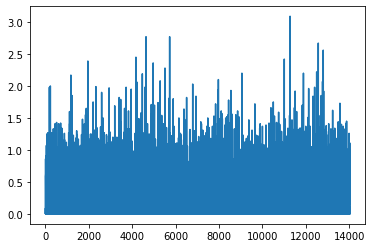

In [57]:
e
np.mean(mean_rewards)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(mean_rewards)

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
#actions = policy(torch.from_numpy(np.array(states)[0]).float().to(device)).squeeze().cpu().detach().numpy()      
print(states[0])
actions = policy(torch.from_numpy(states[0]).float().to(device)).squeeze().cpu().detach().numpy()      
print(actions)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```